# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Цель:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd 
import numpy as np

import time 

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

## Подготовка данных

In [2]:
df_car = pd.read_csv('/datasets/autos.csv')
df_car.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
def df_info(df):
    print(df.shape)
    print(df.info())
    
    if df.isna().values.any():
        display(pd.DataFrame(df.isna().mean().to_frame(name='gaps')).style.format({'gaps' : '{:.2%}'}))
    else: print('No gaps')
        
    
    print('есть ли дупликаты',df.duplicated().values.any())
    
    display(df.head(10))
df_info(df_car)

(354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int6

,gaps
DateCrawled,0.00%
Price,0.00%
VehicleType,10.58%
RegistrationYear,0.00%
Gearbox,5.60%
Power,0.00%
Model,5.56%
Kilometer,0.00%
RegistrationMonth,0.00%
FuelType,9.28%


есть ли дупликаты True


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
df_car.drop_duplicates(inplace=True)
df_car.duplicated().values.any()

False

- Пропуски можно удалить для моделей не использующие градиентный бустинг, как не думаю , что можно корректоно их заполнить или восстановить тк нет зависимости между признаками 
- или заменить на запись **unknown**

удалим даты и PostalCode тк они не понадобятся при обучении

In [5]:
df_car.drop(columns = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], inplace=True)

In [6]:
# df = df_car.dropna()
df = df_car.fillna('unknown')
df.isna().values.any()

False

In [7]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


<AxesSubplot:>

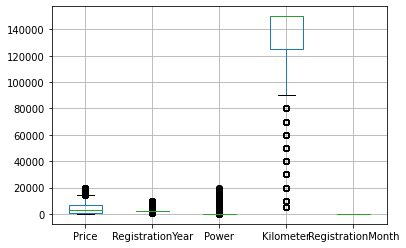

In [8]:
df.boxplot(column=['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'])

In [9]:
for col in ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']:
    print('-----', col, '----')
    print(df[col].unique())
    print('==================')

----- Price ----
[  480 18300  9800 ... 12395 18429 10985]
----- RegistrationYear ----
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]
----- Power ----
[    0   190   163    75    69   102   109    50   125   101   105   140
   115   131    60   136   160   231    90   118   193  

In [10]:
df.loc[df['Power'] > 1500, 'Power'] = 0

In [11]:
df['Power'].unique()

array([   0,  190,  163,   75,   69,  102,  109,   50,  125,  101,  105,
        140,  115,  131,   60,  136,  160,  231,   90,  118,  193,   99,
        113,  218,  122,  129,   70,  306,   95,   61,  177,   80,  170,
         55,  143,   64,  286,  232,  150,  156,   82,  155,   54,  185,
         87,  180,   86,   84,  224,  235,  200,  178,  265,   77,  110,
        144,  120,  116,  184,  126,  204,   88,  194,  305,  197,  179,
        250,   45,  313,   41,  165,   98,  130,  114,  211,   56,  201,
        213,   58,  107,   83,  174,  100,  220,   85,   73,  192,   68,
         66,  299,   74,   52,  147,   65,  310,   71,   97,  239,  203,
          5,  300,  103,  258,  320,   63,   81,  148,   44,  145,  230,
        280,  260,  104,  188,  333,  186,  117,  141,   59,  132,  234,
        158,   39,   92,   51,  135,   53,  209,   43,  146,   67,  106,
        166,  276,  344,   72,  249,  237,  245,  111,  326,  279,   23,
        138,  175,   96,  226,   26,   37,  301,  3

In [12]:
df.loc[(df['RegistrationYear'] < 1900 ) | (df['RegistrationYear'] > 2023), 'RegistrationYear'] = 0

In [13]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973,    0, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959,
       1956, 1941, 1962, 1929, 1957, 1940, 1949, 2019, 1937, 1951, 1953,
       1933, 1950, 1948, 1952, 1932, 1942, 1935, 1936, 1923, 1930, 1944,
       1943, 1934, 1938, 1928, 1919, 1931, 1915, 1920, 1947, 1927, 1946])

- **Достаточно много аномальных значаний в 2 колонках , все аномальные значения я перевел в 0 (как не известные)**

отдельно сделаем переменную для категориальных прихнаков , понадобиться и в преобразовании в численный тип данных и для градиентного бустинга 

In [14]:
cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'RegistrationYear', 'RegistrationMonth']
num_col = ['Power', 'Kilometer']

так же посмотрим как коррелируют данные

In [15]:
# plt.subplots(figsize=(9, 6))
# sns.heatmap(df.corr(), annot=True, fmt=".1f")

In [16]:
y = df['Price']
X = df.drop(columns=('Price'))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

## Обучение моделей

- Напишем функцию для подсчета времени и лучшего скора

In [18]:
def model_time(model, features_train, target_train, features_test, target_test, cv):
    now = time.time()
    model.fit(features_train, target_train)
    training_time = time.time() - now
    
    now = time.time()
    predicted = model.predict(features_test)
    predict_time = time.time() - now
    rmse = mean_squared_error(target_test, predicted, squared=False)
    
    all_time = training_time + predict_time
    
    return training_time, predict_time, all_time, rmse, -cv

### LinearRegression

In [20]:
%%time

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), num_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                   ('classifier', LogisticRegression(solver='lbfgs'))]) 

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

params = {'model__fit_intercept' : [True, False]
         , 'model__copy_X' : [True, False]
         }
rs_lr = RandomizedSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

model_random_lr = rs_lr.fit(X_train,y_train)

# random random search results
best_lr_params = model_random_lr.best_params_
print('Best random search hyperparameters are: '+str(model_random_lr.best_params_))
print('Best random search score is: '+str(-model_random_lr.best_score_))

Best random search hyperparameters are: {'model__fit_intercept': False, 'model__copy_X': True}
Best random search score is: 2296.3688753229585
CPU times: user 2min 21s, sys: 3min 59s, total: 6min 21s
Wall time: 6min 22s


In [21]:
%%time
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LinearRegression())
])

params = {'model__fit_intercept' : [True, False]
         , 'model__copy_X' : [True, False]
         }
rs_lr = RandomizedSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

model_random_lr = rs_lr.fit(X_train,y_train)

# random random search results
best_lr_params = model_random_lr.best_params_
print('Best random search hyperparameters are: '+str(model_random_lr.best_params_))
print('Best random search score is: '+str(-model_random_lr.best_score_))

Best random search hyperparameters are: {'model__fit_intercept': True, 'model__copy_X': True}
Best random search score is: 2140.867800409463
CPU times: user 23.3 s, sys: 30.8 s, total: 54.1 s
Wall time: 54.4 s


In [22]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context
pipe  

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore')),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', LinearRegression())])

In [23]:
lr = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LinearRegression(fit_intercept=True, copy_X=True))
]) 

lr_model = lr.fit(X_train,y_train)

predict_ = lr_model.predict(X_test)

mean_squared_error(y_test, predict_, squared= False)

2149.7264870251606

In [24]:
lr_m = model_time(lr, X_train, y_train, X_test, y_test, model_random_lr.best_score_)

### Ridge

In [25]:
%%time



# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                   ('classifier', LogisticRegression(solver='lbfgs'))]) 

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(random_state=12345))
])

params = {'model__fit_intercept' : [True, False]
         , 'model__copy_X' : [True, False]
         , 'model__alpha': np.logspace(-2, 3, 20)
         }
rs_ridge = RandomizedSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

model_random_ridge = rs_ridge.fit(X_train,y_train)

# random random search results
best_ridge_params = model_random_ridge.best_params_
print('Best random search hyperparameters are: '+str(model_random_ridge.best_params_))
print('Best random search score is: '+str(-model_random_ridge.best_score_))

Best random search hyperparameters are: {'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 0.11288378916846889}
Best random search score is: 2295.824126014539
CPU times: user 26.1 s, sys: 1.07 s, total: 27.1 s
Wall time: 27.2 s


In [26]:
ridge = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', Ridge(fit_intercept=True, copy_X=True, alpha=545.5, random_state=12345))
])

In [27]:
r_m = model_time(ridge, X_train, y_train, X_test, y_test, model_random_ridge.best_score_)

###  LightGBM

In [29]:
%%time
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='ignore'), cat_col)]
    , remainder='passthrough')

pipe_1 = Pipeline([
    ('encoder', preprocessor),
    ('lgbm', LGBMRegressor(boosting_type='gbdt', random_state=12345))
    
])

# lgbm = LGBMRegressor(boosting_type='gbdt', random_state=12345)
params = {
    'lgbm__learning_rate': np.logspace(-3, 0, 5),
    'lgbm__n_estimators': [40, 60],
    'lgbm__num_leaves': [31, 41, 51]
}

gs_gbm =  RandomizedSearchCV(pipe_1, params, cv=3, scoring='neg_root_mean_squared_error', verbose=True)

model_random_gbm = gs_gbm.fit(X_train,y_train)

# random random search results
best_ridge_params = model_random_gbm.best_params_
print('Best random search hyperparameters are: '+str(model_random_gbm.best_params_))
print('Best random search score is: '+str(-model_random_gbm.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best random search hyperparameters are: {'lgbm__num_leaves': 41, 'lgbm__n_estimators': 40, 'lgbm__learning_rate': 0.1778279410038923}
Best random search score is: 1872.1847546070196
CPU times: user 24min, sys: 8.25 s, total: 24min 8s
Wall time: 24min 21s


In [30]:
pipe_1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'encoder', 'lgbm', 'encoder__n_jobs', 'encoder__remainder', 'encoder__sparse_threshold', 'encoder__transformer_weights', 'encoder__transformers', 'encoder__verbose', 'encoder__cat', 'encoder__cat__categories', 'encoder__cat__dtype', 'encoder__cat__handle_unknown', 'encoder__cat__unknown_value', 'lgbm__boosting_type', 'lgbm__class_weight', 'lgbm__colsample_bytree', 'lgbm__importance_type', 'lgbm__learning_rate', 'lgbm__max_depth', 'lgbm__min_child_samples', 'lgbm__min_child_weight', 'lgbm__min_split_gain', 'lgbm__n_estimators', 'lgbm__n_jobs', 'lgbm__num_leaves', 'lgbm__objective', 'lgbm__random_state', 'lgbm__reg_alpha', 'lgbm__reg_lambda', 'lgbm__silent', 'lgbm__subsample', 'lgbm__subsample_for_bin', 'lgbm__subsample_freq'])

In [31]:
lgbm_best = Pipeline([
    ('encoder', preprocessor),
    ('model', LGBMRegressor(boosting_type='gbdt', num_leaves=31, n_estimators=40, learning_rate=1.0, random_state=12345))
])


In [32]:
lgbm_m = model_time(lgbm_best, X_train, y_train, X_test, y_test, model_random_gbm.best_score_)

### CarBoost

In [33]:
cbr = CatBoostRegressor(random_seed=12345,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=cat_col)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [d for d in range(2, 11)],
}

cat =  RandomizedSearchCV(cbr, params, cv=3, scoring='neg_root_mean_squared_error', verbose=True)

model_random_cat = cat.fit(X_train,y_train)

# random random search results
best_ridge_params = model_random_cat.best_params_
print('Best random search hyperparameters are: '+str(model_random_cat.best_params_))
print('Best random search score is: '+str(-model_random_cat.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best random search hyperparameters are: {'learning_rate': 0.1778279410038923, 'iterations': 60, 'depth': 10}
Best random search score is: 1840.4999202879646


In [34]:
cbr_best = CatBoostRegressor(learning_rate=0.1778279410038923,
                        iterations=60,
                        depth=7,
                        random_seed=12345,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=cat_col)

In [35]:
cbr_m = model_time(cbr_best, X_train, y_train, X_test, y_test, model_random_cat.best_score_)

## Анализ моделей

In [36]:
pd.DataFrame((lr_m, r_m, lgbm_m, cbr_m), index=['LinearRegression', 'Ridge', 'LightGBM', 'CatBoost']
             , columns=['trainig_time', 'predic_time', 'all_time', 'RMSE', 'CV RMSE'])

,trainig_time,predic_time,all_time,RMSE,CV RMSE
LinearRegression,5.247621,0.190802,5.438423,2149.726487,2140.867800
Ridge,0.712509,0.151169,0.863678,2149.638252,2295.824126
LightGBM,13.077517,0.394827,13.472343,1897.606813,1872.184755
CatBoost,9.200554,0.158675,9.359229,1907.477104,1840.499920


### вывод 

- Модель LightGBM c параметрами boosting_type='gbdt', num_leaves=31, n_estimators=40, learning_rate=1.0, random_state=12345 отработала лучше всего:
    - скорость обучения и предсказания в сумме 2.592526
    - точность модели RMSE = 1876.456559